In [1]:
# -*- coding: utf-8 -*-
"""
@author: Crazy Trader
Trading Hours (HKT Timezone) Mon - Fri: 
    HSI Derivatives(Day Session)    : 09:15 - 12:00, 13:00 - 16:30
                   (Night Session)  : 17:15 - 01:00
    HK Equities    (Auction Session): 09:00 - 09:30
                   (Day Session)    : 09:30 - 12:00, 13:00 - 16:08
    US Equities                     : 22:30 - 05:00
    Forex                           : 00:00 - 23:59
Restrictions:
    Trading must be in trading hours
    Trading must be in sufficnet cash
    Option Strike Price is in step of 200
Assumptions:
    Open/Close Rate means Bid/Ask for FX, Close for EQ, and Strike for Options
    Option price based on Interest rate is 0.15% and dividend yield is 4.24%, per year
    no overnight fee incurred
Operations:
    Long with Ask
    Short with Bid
"""

'\n@author: Crazy Trader\nTrading Hours (HKT Timezone) Mon - Fri: \n    HSI Derivatives(Day Session)    : 09:15 - 12:00, 13:00 - 16:30\n                   (Night Session)  : 17:15 - 01:00\n    HK Equities    (Auction Session): 09:00 - 09:30\n                   (Day Session)    : 09:30 - 12:00, 13:00 - 16:08\n    US Equities                     : 22:30 - 05:00\n    Forex                           : 00:00 - 23:59\nRestrictions:\n    Trading must be in trading hours\n    Trading must be in sufficnet cash\n    Option Strike Price is in step of 200\nAssumptions:\n    Open/Close Rate means Bid/Ask for FX, Close for EQ, and Strike for Options\n    Option price based on Interest rate is 0.15% and dividend yield is 4.24%, per year\n    no overnight fee incurred\nOperations:\n    Long with Ask\n    Short with Bid\n'

In [2]:
#%% Library
from functions import *

In [3]:
#%% Params
dataset = {}
dataset['HSI']     = 'EQ'       # Close, Volume
dataset['VHSI']    = 'Vol'      # Close
dataset['VIX']     = 'Vol'      # Close
dataset['USDHKD']  = 'FX'       # Bid, Ask
dataset['XAUHKD']  = 'FX'       # Bid, Ask
dataset['HKDTRY']  = 'FX'       # Bid, Ask
dataset['USDTRY']  = 'FX'       # Bid, Ask
dataset['XRPUSD']  = 'FX'       # Bid, Ask
initdataset(dataset)            # initialize Dataset

In [4]:
#%%
position = {}                   # NONE, LONG, SHORT
position['HSI']     = 'NONE'    # Close, Volume
position['VHSI']    = 'NONE'    # Close
position['PUT']     = 'NONE'    # 
position['CALL']    = 'NONE'    # 
position['XAUHKD']  = 'NONE'    # Bid, Ask
position['USDTRY']  = 'NONE'    # Bid, Ask
position['XRPUSD']  = 'NONE'    # Bid, Ask

In [5]:
#%%
initportfolio(10000000, 100)                                # initialize Account Cash, service fee
start   = '2018-09-01 00:00:00'                             # initialize start date
end     = '2018-10-31 23:59:59'                             # initialize start date
mask = (quote['USDHKD'].index > start) & (quote['USDHKD'].index <= end)
backtestperiod = quote['USDHKD'].loc[mask]
# start looping every 1 minute
prev = None

In [6]:
for time, reference in backtestperiod.iterrows():
    """ 
    Read-Only Params:
    quote['HSI'].loc[time].Close
    quote['HSI'].loc[time].Volume
    quote['VIX'].loc[time].Close
    quote['VHSI'].loc[time].Close
    quote['XAUHKD'].loc[time].Bid
    quote['XAUHKD'].loc[time].Ask
    quote['USDTRY'].loc[time].Bid
    quote['USDTRY'].loc[time].Ask
    quote['XRPUSD'].loc[time].Bid
    quote['XRPUSD'].loc[time].Ask
    
    Trading Methods:
    trade(time, 'XRPUSD', 'LONG',  quote['XRPUSD'].loc[time].Ask, 100000)           # LONG FX Order
    trade(time, 'XRPUSD', 'CLOSE', quote['XRPUSD'].loc[time].Bid, 100000)           # CLOSE FX LONG Order
    trade(time, 'XRPUSD', 'SHORT', quote['XRPUSD'].loc[time].Bid, 100000)           # SHORT FX Order
    trade(time, 'XRPUSD', 'CLOSE', quote['XRPUSD'].loc[time].Ask, 100000)           # CLOSE FX SHORT Order
    trade(time, 'HSI',    'SHORT', quote['HSI'].loc[time].Close,  10)               # LONG EQ Order
    trade(time, 'HSI',    'CLOSE', quote['HSI'].loc[time].Close,  10)               # CLOSE EQ LONG Order
    trade(time, 'CALL',   'SHORT', quote['HSI'].loc[time].Close,  100, 26000, 8)    # SHORT EQ CALL Option
    trade(time, 'CALL',   'CLOSE', quote['HSI'].loc[time].Close,  100)              # CLOSE EQ CALL Option
    """ 
    #Examples: 
    if not prev:
        prev = time        
        continue
    
    if is_eqmktopen(time): 
        if quote['VHSI'].loc[time].Close - quote['VHSI'].loc[prev].Close >= 1 or quote['VIX'].loc[time].Close - quote['VIX'].loc[prev].Close >= 1:
            if position['HSI'] is 'NONE':
                trade(time, 'HSI',  'SHORT', quote['HSI'].loc[time].Close, 10)
                option_strike      = (int(quote['HSI'].loc[time].Close / 200) - 2) * 200
                trade(time, 'CALL', 'LONG',  quote['HSI'].loc[time].Close, 10, option_strike, time.month)
                position['HSI'] = 'SHORT'
                                
        if quote['VHSI'].loc[prev].Close - quote['VHSI'].loc[time].Close >= 1 or quote['VIX'].loc[prev].Close - quote['VIX'].loc[time].Close >= 1:
            if position['HSI'] is not 'NONE':
                position['HSI']    = trade(time, 'HSI',  'CLOSE', quote['HSI'].loc[time].Close, 10)
                position['CALL']   = trade(time, 'CALL', 'CLOSE', quote['HSI'].loc[time].Close, 10)
                position['HSI'] = 'NONE'
                
    if is_fxmktopen(time):  
        if quote['VIX'].loc[time].Close - quote['VIX'].loc[prev].Close >= 1:
            if position['XRPUSD'] is 'NONE':
                trade(time, 'XRPUSD', 'SHORT', quote['XRPUSD'].loc[time].Bid, 10)
                position['XRPUSD'] = 'SHORT'
        
        if quote['VIX'].loc[prev].Close - quote['VIX'].loc[time].Close >= 1:
            if position['XRPUSD'] is not 'NONE':
                trade(time, 'XRPUSD', 'CLOSE', quote['XRPUSD'].loc[time].Ask, 10)
                position['XRPUSD'] = 'NONE'
    prev = time        
    
    ### ADD YOUR CODE HERE ###
    
    ### ADD YOUR CODE HERE ###
    
    # Update position info once a day: Unrealized, realized P&L
    if time.timestamp() % 86400 == 0:
        updatepos(time)

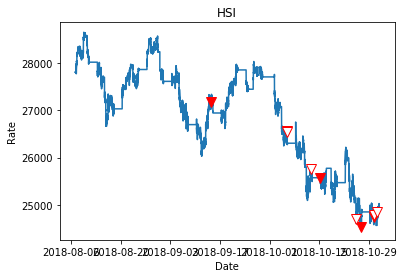

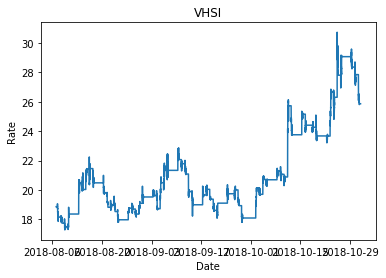

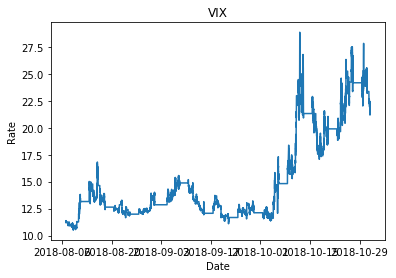

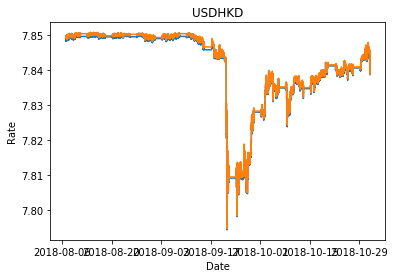

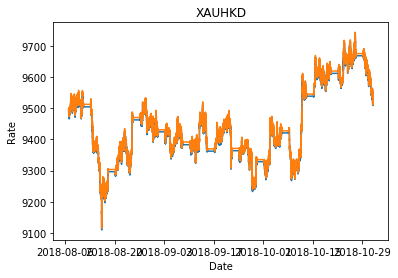

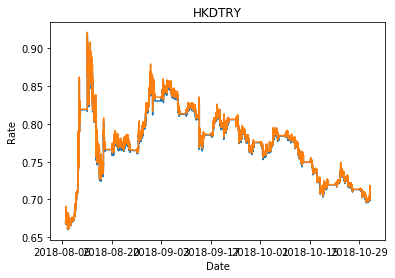

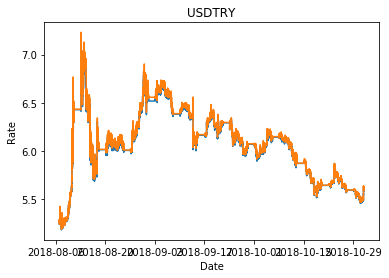

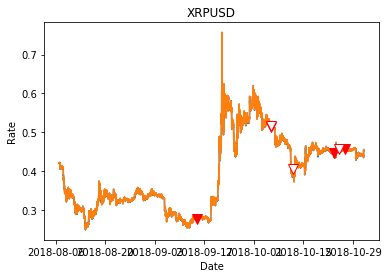

   Product Strike Maturity Position           Open Date     Open Rate Qty  \
0      HSI   None     None    SHORT 2018-09-14 13:02:00  27175.000000  10   
1     CALL  26600        9     LONG 2018-09-14 13:02:00    767.832351  10   
2   XRPUSD   None     None    SHORT 2018-09-15 00:02:00      0.277000  10   
3      HSI   None     None    SHORT 2018-10-05 20:33:00  26568.000000  10   
4     CALL  26000       10     LONG 2018-10-05 20:33:00    874.096142  10   
5   XRPUSD   None     None    SHORT 2018-10-05 20:33:00      0.513030  10   
6      HSI   None     None    SHORT 2018-10-15 09:31:00  25570.000000  10   
7     CALL  25000       10     LONG 2018-10-15 09:31:00    773.558360  10   
8   XRPUSD   None     None    SHORT 2018-10-23 15:16:00      0.446020  10   
9      HSI   None     None    SHORT 2018-10-26 19:04:00  24539.000000  10   
10    CALL  24000       10     LONG 2018-10-26 19:04:00    579.673235  10   
11  XRPUSD   None     None    SHORT 2018-10-26 19:04:00      0.456090  10   

In [7]:
#%% Export Portfolio
portfolio, log = exporttrades()
print (log)
print (portfolio)